# Non-Stationary Noise Analysis of Fluorescence Data

This notebook performs non-stationary noise analysis on a linescan fluorescence experiment stored in the **OME-Zarr** format. The workflow is designed to analyze fluorescence measurements to detect single-channel activity of calcium (Ca²⁺) ions. The key objectives and steps are outlined below:

---

## Key Objectives
1. **Data Access and Preprocessing**:
   - Load fluorescence imaging data in OME-Zarr format.
   - Extract specific time, channel, and spatial dimensions for analysis.
   - Define a time domain based on acquisition parameters.

2. **Integrated Time Series Analysis**:
   - Divide the image into regions of interest along the spatial domain.
   - Compute integrated time series for each region to extract fluorescence dynamics.

3. **Non-Stationary Noise Analysis**:
   - Analyze the data for fluctuations indicative of Ca²⁺ single-channel activity.
   - Utilize a window-based approach to calculate variations in signal across time, focusing on potential channel opening times.

---

## Intended Use Case
This analysis is particularly suited for fluorescence measurements of calcium ions with a putative channel opening time of **10 milliseconds**. The workflow aims to:
- Detect discrete channel events based on fluorescence fluctuations.
- Provide quantitative insights into calcium dynamics using statistical and noise analysis.

---

## Non-Stationary Noise Analysis

The **Non-Stationary Noise Analysis** focuses on assessing time-dependent variations in fluorescence signals to identify single-channel openings:

1. **Window-Based Signal Partitioning**:
   - The signal is divided into time windows of **100 milliseconds** (customizable based on the experiment).
   - Each window is processed to extract statistical noise characteristics.

2. **Noise Analysis Metrics**:
   - Compute variance and mean within each window to observe signal fluctuations.
   - Identify non-stationary behavior indicative of single-channel events.

3. **Single-Channel Activity**:
   - Leverage the calculated metrics to pinpoint transient fluorescence bursts.
   - Compare findings with the expected opening time of **10 milliseconds** for calcium channels.



## Install libraries

In [1]:
print("Installing necessary libraries...")
!pip install ome-zarr > /dev/null 2>&1
print("Libraries installed successfully.")

Installing necessary libraries...
Libraries installed successfully.


## Load libraries

In [2]:
import zarr
from ome_zarr.io import parse_url
import matplotlib.pyplot as plt
import os
import numpy as np
from scipy.optimize import curve_fit
from scipy.ndimage import gaussian_filter

## Define file paths

In [3]:
#directory_path = '/home/jovyan/LNMA/guerreroa/data/20241114'
#filename = '14_11_24_Exp1_TYH_mib_22C_15segundos.zarr'
#filename = '14_11_24_Exp3_TYH_mib_22C_10segundos.zarr'
#filename =  '14_11_24_Exp3_TYH_FB_22C.zarr'
#filename = '14_11_24_Exp5_TYH_mib_22C_10segundos_256x256.zarr'

#directory_path = '/home/jovyan/LNMA/guerreroa/data/20241119'
#filename ='20241119_CTRLXT_ConFluoBG_Ev_Ind_500rep_Perp_C2.zarr'
#filename = '20241119_MBF30uMXT_Ev_Ind_500rep_Perp_20us_C2.zarr'
#filename = '20241119_MBF30uMXT_Ev_Ind_500rep_Perp_12_5us_C2.zarr'
#filename = '20241119_MBF30uMXT_Ev_Ind_500rep_Perp_5us_C2.zarr'
#filename = '20241119_MBF30uMXT_Ev_Ind_500rep_Parl_5us_C2.zarr'
#filename = '20241119_MBF30uMXT_Ev_Ind_500rep_Perp_5us_C2.zarr'

directory_path = '/home/jovyan/LNMA/guerreroa/data/20241120'
#filename = '20241120_CTRLXT_cabeza_16000L_4us_Zo25_128x128_R2_C1.zarr'
filename =  '20241120_MBF15uMXYT_cabeza_4us_Zo25_16000L_128x128_R2_C1.zarr'
#filename = '20241120_IONO10uMXYT_cabeza_4us_Zo25_16000L_128x128_R2_C1.zarr'
ome_zarr_path = os.path.join(directory_path, filename)

## Parameters

In [4]:

num_regions = 3 # Number of regions to split along the X-domain
#window_duration_ms = 100  # Time window in milliseconds
window_duration_ms = 50  # Time window in milliseconds
#window_duration_ms = 20  # Time window in milliseconds
#window_duration_ms = 10  # Time window in milliseconds

#I_step= 1
#Var_step= 1
#sigma_blur = 1


I_step= 50
Var_step= 5000
sigma_blur = 1

## Functions

In [5]:
def plot_integrated_time_series(F5N_image, time_domain, num_regions):
    """
    Plot integrated time series for a given image split into specified regions along the X-axis.
    Return the sub-matrices (regions) of the image.

    Parameters:
        F5N_image (numpy.ndarray): 2D array of the image data (Y, X).
        time_domain (numpy.ndarray): 1D array of time points corresponding to the rows in the image.
        num_regions (int): Number of regions to split the X-domain into.

    Returns:
        list: A list of 2D sub-matrices (regions) obtained by splitting the image.
    """
    # Split the X-domain into `num_regions` regions
    img_rois = np.array_split(F5N_image, num_regions, axis=1)
    
    # Create dynamic region labels
    region_labels = [f"R{i + 1}" for i in range(num_regions)]
    
    # Calculate integrated intensity for each region
    time_series_regions = [sub_matrix.sum(axis=1) for sub_matrix in img_rois]
    
    # Plot all time series
    plt.figure(figsize=(10, 6))
    
    # Plot each region's time series
    for i, time_series in enumerate(time_series_regions):
        plt.plot(time_domain, time_series, label=f"{region_labels[i]}", linewidth=1.5)
    
    # Add plot details
    plt.title("Time Series Integrated Over r for Different Regions")
    plt.xlabel("Time (seconds)")
    plt.ylabel("Integrated Intensity")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return time_series_regions

def non_stationary_noise_analysis(time_series, time_per_line, window_duration_ms=100):
    """
    Perform non-stationary noise analysis on a given time series.

    Parameters:
    - time_series (numpy array): Input time series data for analysis.
    - time_per_line (float): Time per line acquisition in milliseconds.
    - window_duration_ms (int, optional): Duration of the analysis window in milliseconds. Default is 100 ms.

    Returns:
    - results (dict): A dictionary containing mean values, variance values, and window indices.
    """
    # Calculate window size and number of windows
    window_size = int(window_duration_ms / time_per_line)  # Convert to number of samples
    num_windows = len(time_series) // window_size

    # Initialize lists to store results
    mean_values = []
    variance_values = []
    window_indices = []

    # Perform analysis for each window
    for i in range(num_windows):
        start_idx = i * window_size
        end_idx = start_idx + window_size
        window_data = time_series[start_idx:end_idx]

        # Calculate mean and variance for the window
        mean_values.append(np.mean(window_data))
        variance_values.append(np.var(window_data))
        window_indices.append(i * (window_duration_ms / 1000))  # Convert to seconds

    # Plot results
    plt.figure(figsize=(12, 6))

    # Plot mean values
    plt.subplot(2, 1, 1)
    plt.plot(window_indices, mean_values, label="Mean", marker='o')
    plt.title("Non-Stationary Noise Analysis")
    plt.xlabel("Time (seconds)")
    plt.ylabel("Mean Intensity")
    plt.grid(True)
    plt.legend()

    # Plot variance values
    plt.subplot(2, 1, 2)
    plt.plot(window_indices, variance_values, label="Variance", marker='o', color='orange')
    plt.xlabel("Time (seconds)")
    plt.ylabel("Variance")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Return results as a dictionary
    results = {
        "mean_values": mean_values,
        "variance_values": variance_values,
        "window_indices": window_indices
    }

    return results
def variance_model_with_background(I, i, N, B):
    """
    Model equation for variance: Var = i*I - (I^2 / N) + B.

    Parameters:
        I (array): Mean intensities.
        i (float): Scaling parameter.
        N (float): Parameter related to system noise.
        B (float): Background signal.

    Returns:
        array: Calculated variance for given intensities.
    """
    return i * I - (I**2) / N + B


def bin_data_with_step(I, Var, I_step=1, Var_step=1):
    """
    Bin the data by averaging within specified steps of I and Var.

    Parameters:
        I (array): Mean intensities.
        Var (array): Variances.
        I_step (float): Step size for binning in I.
        Var_step (float): Step size for binning in Var.

    Returns:
        tuple: Binned mean intensities and variances.
    """
    # Ensure I and Var are numpy arrays
    I = np.array(I)
    Var = np.array(Var)

    # Create bins based on step sizes
    I_bins = np.floor(I / I_step).astype(int)
    unique_bins = np.unique(I_bins)

    # Calculate binned mean intensities and variances
    binned_I = []
    binned_Var = []
    for b in unique_bins:
        mask = I_bins == b
        if np.any(mask):  # Avoid empty bins
            binned_I.append(np.mean(I[mask]))
            binned_Var.append(np.mean(Var[mask]))

    return np.array(binned_I), np.array(binned_Var)

def fit_and_plot_variance_with_background_binned_step(I, Var, region_label, I_step=1, Var_step=1):
    """
    Bin the data with specified steps, fit the variance model with background signal, and plot the results.

    Parameters:
        I (array): Mean intensities.
        Var (array): Variances.
        region_label (str): Label for the region being analyzed.
        I_step (float): Step size for binning in I.
        Var_step (float): Step size for binning in Var.

    Returns:
        dict: Fitted parameters {i, N, B} and their uncertainties.
    """
    # Bin the data with specified steps
    binned_I, binned_Var = bin_data_with_step(I, Var, I_step, Var_step)
    if (len(binned_I) < 5):
        return
    if (len(binned_Var) < 5):
        return
    # Fit the variance model with background
    popt, pcov = curve_fit(variance_model_with_background, binned_I, binned_Var, p0=[1, 100, 0])
    i, N, B = popt
    perr = np.sqrt(np.diag(pcov))  # Standard deviations of parameters

    # Generate data for the fitted curve
    I_fit = np.linspace(min(binned_I), max(binned_I), 100)
    Var_fit = variance_model_with_background(I_fit, i, N, B)

    # Plot the binned data and the fit
    plt.figure(figsize=(8, 6))
    plt.scatter(binned_I, binned_Var, label="Binned Data", color="blue", alpha=0.7)
    plt.plot(I_fit, Var_fit, label=f"Fit: Var = {i:.3f}*I - (I^2 / {N:.3f}) + {B:.3f}", color="red", linewidth=2)
    plt.title(f"Variance vs Intensity (Binned with step, {region_label})")
    plt.xlabel("Mean Intensity (I)")
    plt.ylabel("Variance (Var)")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Return fitted parameters and uncertainties
    return {"i": i, "N": N, "B": B, "i_std": perr[0], "N_std": perr[1], "B_std": perr[2]}




## Load and Display Metadata from OME-Zarr

In [6]:
# Load the OME-Zarr file
root = zarr.open(ome_zarr_path, mode="r")
print(root.tree())
# Display metadata
image_metadata = root.attrs.get("image_metadata", {})

#print("Image Metadata:", image_metadata)

image_date = image_metadata.get('Acquisition Parameters Common', {}).get('ImageCaputreDate', 'Date not found')
print("Image Date:", image_date)

channel_1 = image_metadata.get('Channel 1 Parameters', {}).get('DyeName', 'DyeName not found')
channel_2 = image_metadata.get('Channel 2 Parameters', {}).get('DyeName', 'DyeName not found')

print("Channel 1", channel_1)
print("Channel 2", channel_2)

# Retrieve PhysicalSizeY from Reference Image Parameter
physical_size_y = image_metadata.get('Reference Image Parameter', {}).get('HeightConvertValue', 'PhysicalSizeY not found')
print("Physical Size Y:", physical_size_y)

# Retrieve ScanSpeed, Time Per Frame, Time Per Line, and Time Per Pixel
scan_speed = image_metadata.get('Acquisition Parameters Common', {}).get('SamplingClock', 'ScanSpeed not found')
time_per_frame = image_metadata.get('Axis 4 Parameters Common', {}).get('EndPosition', 'Time Per Frame not found')

pixel_size = image_metadata.get('Reference Image Parameter', {}).get('WidthConvertValue', 'Time Per Pixel not found')
print("Scan Speed:", scan_speed)
print("Time Per Frame:", time_per_frame)
print("Pixel Size:", pixel_size)

/
 └── image_data (1, 2, 1, 16000, 48) uint16
Image Date: 2024-11-20 16:40:29
Channel 1 fluo-5N
Channel 2 None
Physical Size Y: 0.066
Scan Speed: 250000
Time Per Frame: 20735.984
Pixel Size: 0.066


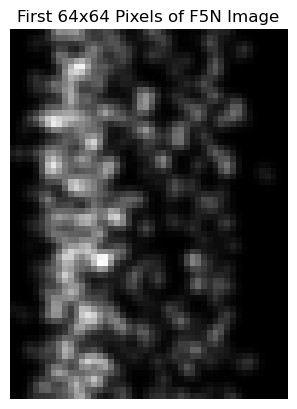

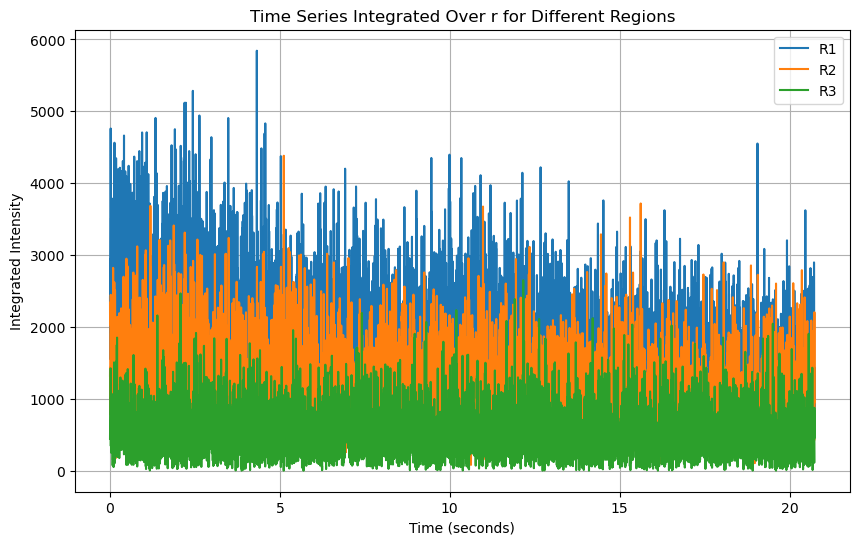

1.2959990000000001

In [7]:
# Access the Fluo - 5N image slice (T=0, C=3, Z=0), adjust as needed based on dimensionality
F5N_image = root["image_data"][0, 0, 0, :, :]  # Assuming (T, C, Z, Y, X) format

# Apply Gaussian blur 
if (sigma_blur):
    F5N_image = gaussian_filter(F5N_image, sigma = sigma_blur)

time_per_line = itime_per_line = time_per_frame/len(F5N_image)
# Convert time to seconds
time_domain = np.arange(len(F5N_image)) * (time_per_line / 1000)  # Time domain in seconds


# Slice the first 64x64 pixels
F5N_image_64x64 = F5N_image[:64, :64]

# Display the first 64x64 pixels
plt.imshow(F5N_image_64x64, cmap="gray")
#plt.imshow(F5N_image, cmap="gray")
plt.title("First 64x64 Pixels of F5N Image")
plt.axis("off")
plt.show()

# Integrate the time series of each region 
time_series_regions = plot_integrated_time_series(F5N_image, time_domain, num_regions)
time_per_line

In [8]:

time_series =time_series_regions[0]
# Parameters for the non-stationary noise analysis
window_size = int(window_duration_ms / time_per_line)  # Convert to number of samples
num_windows = len(time_series) // window_size


# Run the analysis
#results = non_stationary_noise_analysis(time_series, time_per_line, window_duration_ms)

# Access the results
#mean_values = results["mean_values"]
#variance_values = results["variance_values"]
#window_indices = results["window_indices"]
print(time_per_line)

1.2959990000000001


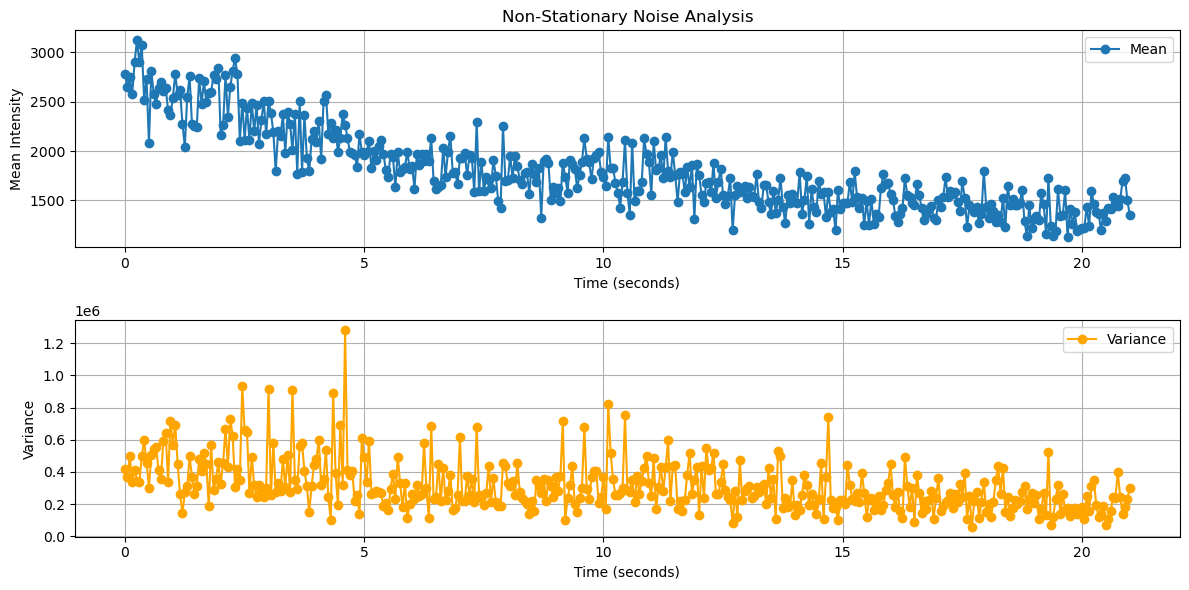

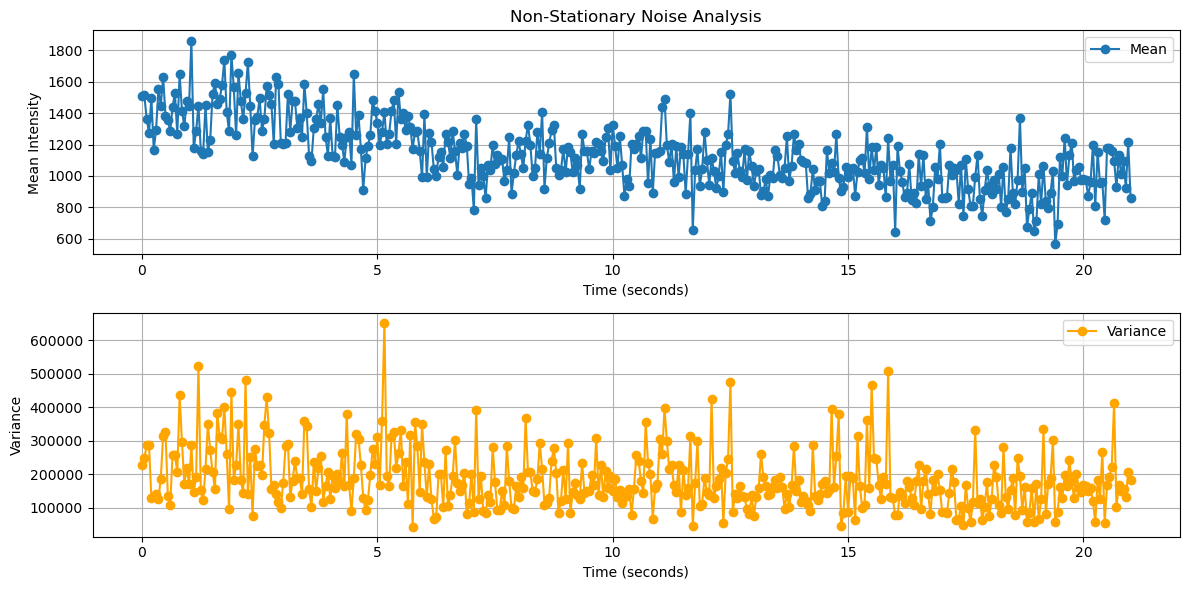

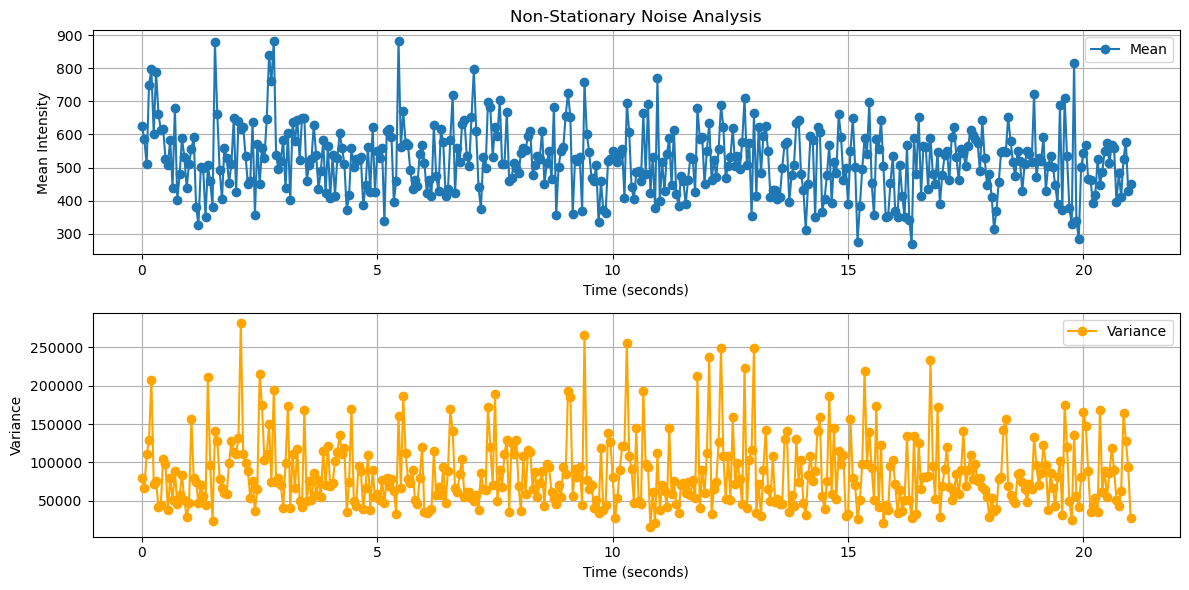

Number of regions (list length): 3


In [9]:

accumulated_results = []

for time_series in time_series_regions:
    region_result = non_stationary_noise_analysis(time_series, time_per_line, window_duration_ms)
    accumulated_results.append(region_result)


# Check the number of items in the list
print("Number of regions (list length):", len(accumulated_results))

In [10]:
# List to store extracted data
means = []
variances = []

# Determine the number of regions
num_regions = len(accumulated_results)

# Generate region labels dynamically
regions = [f"R{i + 1}" for i in range(num_regions)]

# Output the regions for verification
print("Generated region labels:", regions)

# Dynamically extract data from the results
#for region_result in accumulated_results:
#    means.append(region_result["mean_values"])
#    variances.append(region_result["variance_values"])

# Extract means and variances as NumPy arrays
means = [np.array(region_result["mean_values"]) for region_result in accumulated_results]
variances = [np.array(region_result["variance_values"]) for region_result in accumulated_results]


Generated region labels: ['R1', 'R2', 'R3']


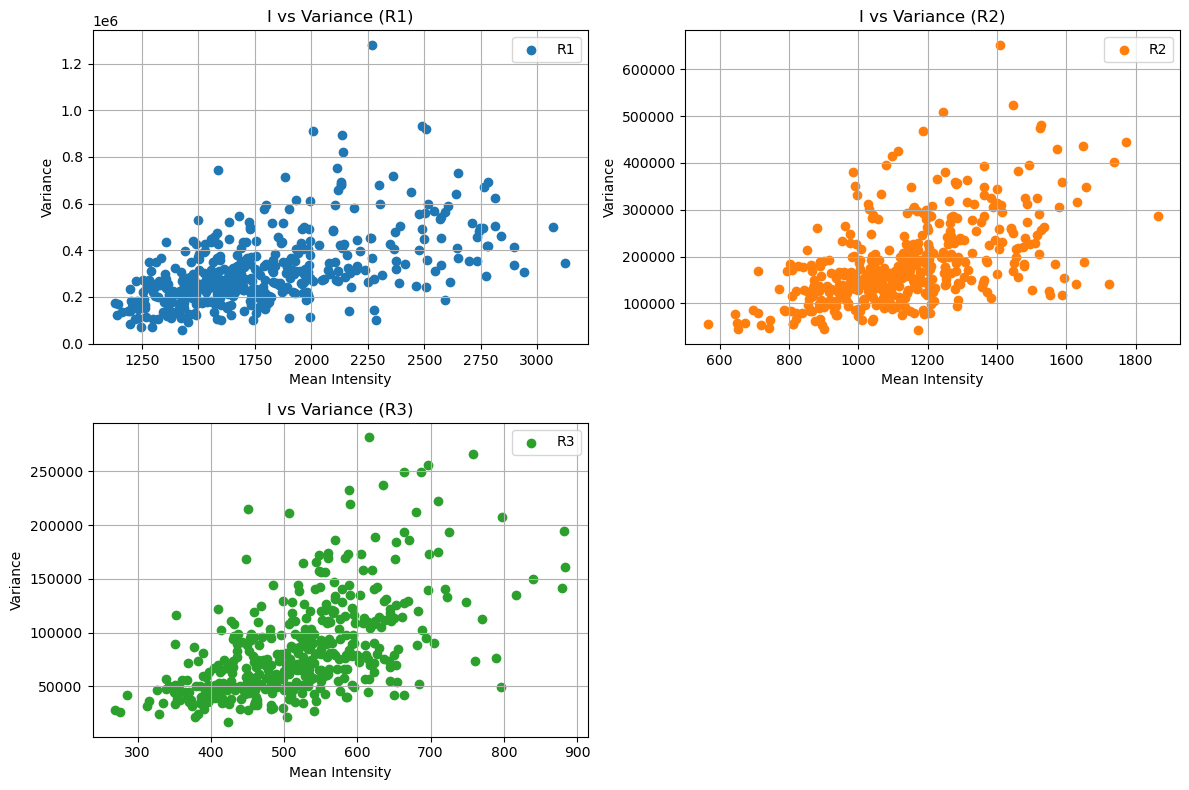

In [11]:
import matplotlib.pyplot as plt
import math


# Calculate the grid size for subplots
cols = 2  # Number of columns (adjust if desired)
rows = math.ceil(num_regions / cols)  # Calculate rows based on number of regions

# Set up the plot
plt.figure(figsize=(12, 4 * rows))  # Adjust height dynamically based on rows

# Loop through regions and plot
for i, region in enumerate(regions):
    plt.subplot(rows, cols, i + 1)  # Dynamically position each subplot
    plt.scatter(means[i], variances[i], label=region, color=f'C{i % 10}')  # Use modulo for color cycling
    plt.title(f"I vs Variance ({region})")
    plt.xlabel("Mean Intensity")
    plt.ylabel("Variance")
    plt.grid(True)
    plt.legend()
    # Adjust these limits based on the expected range in your data
   # plt.xlim(0, 1750)  # Adjust for mean intensity range
   # plt.ylim(0, 17000)  # Adjust for variance range

plt.tight_layout()
plt.show()


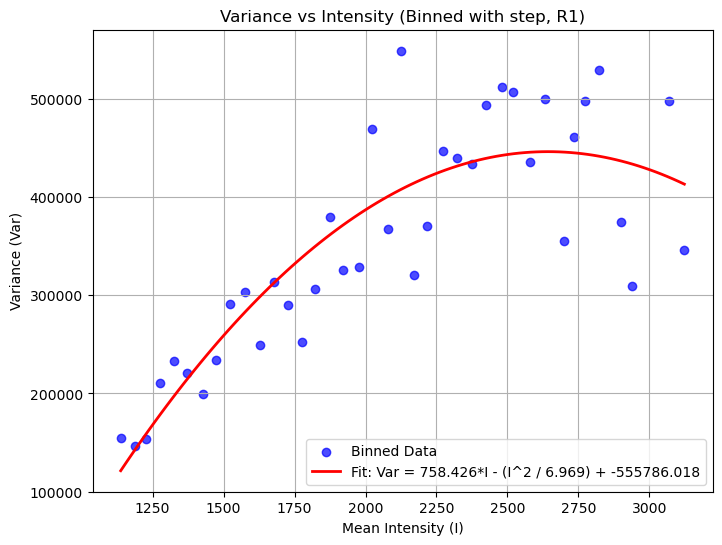

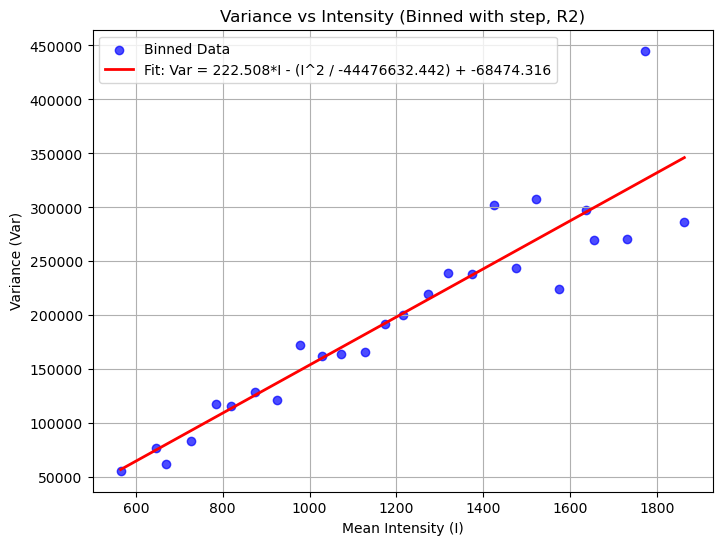

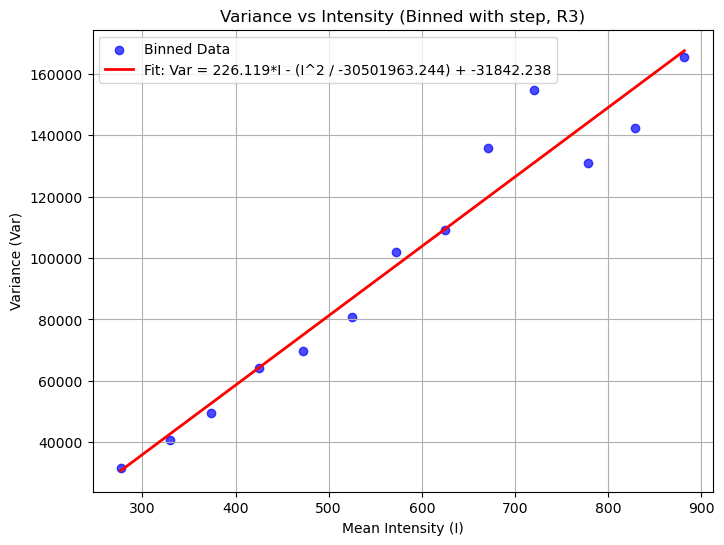

{'R1': {'i': 758.4260370466758,
  'N': 6.969304562611492,
  'B': -555786.0178251181,
  'i_std': 133.09656224344894,
  'N_std': 1.5270259898658614,
  'B_std': 133274.75306137622},
 'R2': {'i': 222.50845468820486,
  'N': -44476632.44208534,
  'B': -68474.31590092443,
  'i_std': 134.87642420826253,
  'N_std': 54315434179934.13,
  'B_std': 76373.42143115832},
 'R3': {'i': 226.11932966876395,
  'N': -30501963.244091913,
  'B': -31842.237669975628,
  'i_std': 87.31974229510888,
  'N_std': 49552957016043.24,
  'B_std': 24701.884829293147}}

In [12]:
# Fit and plot for each region with binned data and specified step
fit_results_with_background_binned_step = {}

for i, label in enumerate(regions):
    fit_results_with_background_binned_step[label] = fit_and_plot_variance_with_background_binned_step(
        means[i] , variances[i], label, I_step, Var_step
    ) 

fit_results_with_background_binned_step
